In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
df = pd.read_csv("../data/clean_tickers/YNDX.csv")

In [11]:
groups = df.groupby("DATE")

In [12]:
prices_by_date = groups["PRICE"].apply(list).to_dict()

In [13]:
time = list(groups["TIME"].get_group(20150302))

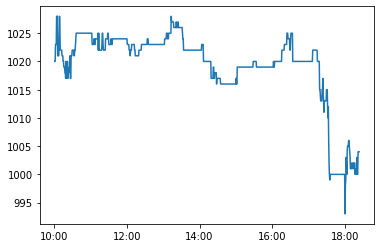

In [14]:
from matplotlib.ticker import FuncFormatter

first_date_prices = prices_by_date[list(prices_by_date.keys())[0]]
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x_val, tick_pos: str(x_val)[0:2] + ":" + str(x_val)[2:4]))
ax.plot(time, first_date_prices);


In [15]:
import math


def log_returns(prices_by_date):
	returns = []
	for price_list in prices_by_date.values():
		returns.append([math.log(price_list[i + 1]) - math.log(price_list[i]) for i in range(len(price_list) - 1)])
	return returns

In [16]:
returns = log_returns(prices_by_date)
assert len(time) == len(returns[0]) + 1

In [17]:
# return [day_1_dataset, day_2_dataset, ...]
# day_1_dataset = ([predictors_1_list, predictors_2_list, ...], [y_1, y_2, ...])
def autoregressive(returns, n_pred):
	date_return_len = len(returns[0])
	result = []
	for date_return in returns:
		assert len(date_return) == date_return_len
		y = date_return[n_pred:]
		predictors = [date_return[i:i + n_pred] for i in range(len(date_return) - n_pred)]
		result.append((predictors, y))
	return result

In [18]:
dataset_by_day = autoregressive(returns, 5)
assert len(dataset_by_day) == len(returns)

In [19]:
def train_test_split(dataset_by_day, ratio=0.7):
	train_size = int(round(len(dataset_by_day) * ratio))
	return dataset_by_day[:train_size], dataset_by_day[train_size:]

In [20]:
train_dataset_by_day, test_dataset_by_day = train_test_split(dataset_by_day, ratio=0.7)

In [21]:
def extract_x_y(dataset_by_day):
	X = sum((day_dataset[0] for day_dataset in dataset_by_day), [])
	y = sum((day_dataset[1] for day_dataset in dataset_by_day), [])
	return X, y

In [22]:
X_train, y_train = extract_x_y(train_dataset_by_day)
X_test, y_test = extract_x_y(test_dataset_by_day)

In [23]:
len(X_train), len(y_train)

(145116, 145116)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [25]:
pipe.score(X_test, y_test), pipe.score(X_train, y_train)

(0.004384943738201197, 0.009919161197278759)

In [26]:
pipe[1].coef_

array([-1.33951057e-05, -2.37947524e-05, -1.41615458e-05, -4.16717938e-05,
       -1.01531882e-04])

In [27]:
pipe[1].intercept_

-1.5582000189878425e-06